In [1]:
import sys, os
from tqdm import tqdm
import numpy as np
import argparse
import json
from shutil import copyfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [56]:
config = {'model': 'ResNet',
 'model_size': 8,
 'activation': 'relu',
 'window_size': {'x': 10, 'y': 10},
 'dropout': 0.0,
 'workers_training': 4,
 'workers_testing': 4,
 'machine': 'barracuda',
 'batch_size': 32}

In [57]:
size_window = (config['window_size']['y'], config['window_size']['x'])
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Import Dataloader 

In [58]:
# Path to dataclass
sys.path.append('../src/Deep_Features/')
from dataloader_2d import build_data_loader

In [59]:

import torch
import torch.nn as nn

from functools import partial

class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)  


def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels,Features = False, activation='relu'):
        super().__init__()
        self.Features = Features
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels


class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels))


class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x


class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by layers with increasing features.
    """
    def __init__(self, in_channels=1, blocks_sizes=[64, 128, 256, 512], depths=[2,2,2,2], 
                 activation='relu', block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation_func(activation),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=depths[0], activation=activation, 
                        block=block,*args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, depths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x


class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes,Features, dropout=0.0):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        if Features:
            self.decoder = nn.Sequential(nn.Dropout(p=1.0-dropout),
                nn.Identity(in_features)
                                        )   
        else:
            self.decoder = nn.Sequential(
                nn.Dropout(p=1.0-dropout),
                nn.Linear(in_features, n_classes)
            )

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x


class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes,Features, dropout=0.0, *args, **kwargs):
        super().__init__()
        self.Features = Features
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes,Features, dropout)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def resnet(size, in_channels, n_classes,Feat, *args, **kwargs):
    layer_depths = {
        5:   [1, 1, 1, 1],
        6:   [1, 1, 1, 1],
        7:   [1, 1, 1, 1],
        8:   [1, 1, 1, 1],
        9:   [1, 1, 1, 1],
        10:  [1, 1, 1, 1],
        18:  [2, 2, 2, 2], 
        34:  [3, 4, 6, 3],
        50:  [3, 4, 6, 3],
        101: [3, 4, 23, 3],
        152: [3, 8, 36, 3]
    }
    blocks = {
        5:   ResNetBasicBlock,
        6:   ResNetBasicBlock,
        7:   ResNetBasicBlock,
        8:   ResNetBasicBlock,
        9:   ResNetBasicBlock,
        10:  ResNetBasicBlock,
        18:  ResNetBasicBlock,
        34:  ResNetBasicBlock,
        50:  ResNetBottleNeckBlock,
        101: ResNetBottleNeckBlock,
        152: ResNetBottleNeckBlock
    }
    channel_dims = {
        5:   [2, 4, 8, 16],
        6:   [4, 8, 16, 32],
        7:   [8, 16, 32, 64],
        8:   [16, 32, 64, 128],
        9:   [32, 64, 128, 256],
        10:  [64, 128, 256, 512],
        18:  [64, 128, 256, 512],
        34:  [64, 128, 256, 512],
        50:  [64, 128, 256, 512],
        101: [64, 128, 256, 512],
        152: [64, 128, 256, 512]
    }
    assert layer_depths.keys() == blocks.keys()
    assert size in layer_depths.keys()
    return ResNet(in_channels, n_classes,Features = Feat, block=blocks[size], blocks_sizes=channel_dims[size], depths=layer_depths[size], *args, **kwargs)

In [60]:
# Import path to directory folder 
path = os.path.split(os.getcwd())[0]+'/src/Deep_Features'
#path = os.path.join(path,'/src/Deep_Features')

In [72]:
import pandas as pd

Train = pd.DataFrame()
' Splitt the data Set into two sets for training and for testing '

Ind = np.random.choice(327,1)
Train_Paths = []
Train_Paths_Labels = []
Num_List = []

for im_num in Ind:
    Num_List.append(im_num)
    if len(str(im_num)) == 3:
        path_1 = '../../FM_Eikonal/data/weizmann_horse_db/horse/horse'+str(im_num)+".png"
        path_2 = '../../FM_Eikonal/data/weizmann_horse_db/mask//horse'+str(im_num)+".png"
        Train_Paths.append(path_1)
        Train_Paths_Labels.append(path_2)
    elif len(str(im_num)) == 2:
        path_1 = '../../FM_Eikonal/data/weizmann_horse_db/horse/horse0'+str(im_num)+".png"
        path_2 = '../../FM_Eikonal/data/weizmann_horse_db/mask//horse0'+str(im_num)+".png"
        Train_Paths.append(path_1)
        Train_Paths_Labels.append(path_2)
    elif len(str(im_num)) == 1 and im_num != 0:
        path_1 = '../../FM_Eikonal/data/weizmann_horse_db/horse/horse00'+str(im_num)+".png"
        path_2 = '../../FM_Eikonal/data/weizmann_horse_db/mask//horse00'+str(im_num)+".png"
        Train_Paths.append(path_1)
        Train_Paths_Labels.append(path_2)

' Train_Set '
D_Train = pd.DataFrame({'Train_Path':Train_Paths,'Train_Path_Labels':Train_Paths_Labels})

' Test_Set '
Test_Paths = []
Test_Paths_Labels = []
for k in range(1,327):
    if k not in Num_List:
        if len(str(k)) == 3:
            path_1 = '../../FM_Eikonal/data/weizmann_horse_db/horse/horse'+str(k)+".png"
            path_2 = '../../FM_Eikonal/data/weizmann_horse_db/mask//horse'+str(k)+".png"
            Test_Paths.append(path_1)
            Test_Paths_Labels.append(path_2)
        elif len(str(k)) == 2:
            path_1 = '../../FM_Eikonal/data/weizmann_horse_db/horse/horse0'+str(k)+".png"
            path_2 = '../../FM_Eikonal/data/weizmann_horse_db/mask//horse0'+str(k)+".png"
            Test_Paths.append(path_1)
            Test_Paths_Labels.append(path_2)
        elif len(str(k)) == 1 and im_num != 0:
            path_1 = '../../FM_Eikonal/data/weizmann_horse_db/horse/horse00'+str(k)+".png"
            path_2 = '../../FM_Eikonal/data/weizmann_horse_db/mask//horse00'+str(k)+".png"
            Test_Paths.append(path_1)
            Test_Paths_Labels.append(path_2)
        if k >1:
            break
        
D_Test = pd.DataFrame({'Test_Path':Test_Paths,'Test_Path_Labels':Test_Paths_Labels})

D_Train.to_csv('../src/Deep_Features/training_data.csv')
D_Test.to_csv('../src/Deep_Features/testing_data.csv')

In [73]:
c = 2
model = resnet(config['model_size'], 1, c, dropout=config['dropout'],Feat=False)
size_window = (config['window_size']['x'],config['window_size']['y'])

fully_convolutional = (config['model'] in ['ResNet'])
model.to(device)

train_dataloader = build_data_loader(size_window, c,path_dir=path,
    train=True,
    batch_size=config['batch_size'],
    workers=config['workers_training'],
    single_pixel_out=(not fully_convolutional))

test_dataloader = build_data_loader(
    size_window, c,path_dir=path,
    train=False,
    batch_size=config['batch_size'],
    workers=config['workers_testing'],
    single_pixel_out=(not fully_convolutional))
test_iter = iter(test_dataloader)



In [74]:
# Train_Model

In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.01)


log_interval = int(1e3)
save_interval = int(1e4)
num_test_batches = 20

running_loss = 0.0

for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(train_dataloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if fully_convolutional:
            # add channel dimension
            inputs = inputs.unsqueeze(1)
        else:
            labels = labels.flatten()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        if fully_convolutional:
            # remove channel dimension
            outputs = torch.squeeze(outputs, dim=1)
        loss = criterion(outputs, labels[:,0,0])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % log_interval == log_interval-1:
            print(f"batch {i} training loss {running_loss / log_interval}")
            running_loss = 0.0
            # run testing
            model.eval()
            test_loss = 0.0
            for test_batches in range(num_test_batches):
                try:
                    test_data, test_labels = next(test_iter)
                except StopIteration:
                    test_iter = iter(test_dataloader)
                    test_data, test_labels = next(test_iter)
                if fully_convolutional:
                    test_data = test_data.unsqueeze(1)
                else:
                    test_labels = test_labels.flatten()
                test_data = test_data.to(device)
                test_labels = test_labels.to(device)
                test_out = model(test_data)
                if fully_convolutional:
                    test_out = torch.squeeze(test_out, 1)
                test_loss += criterion(test_out, test_labels[:,0,0]).item()
            print(f"batch {i} testing loss {test_loss / num_test_batches}")
            model.train()

    print("Finished epoch. Saving model...")
print('Finished Training')

batch 999 training loss 0.5501869230866432
batch 999 testing loss 0.6561069503426552
batch 1999 training loss 0.5504361751973629
batch 1999 testing loss 0.5772193163633347
batch 2999 training loss 0.549860578417778
batch 2999 testing loss 0.5112241372466088
batch 3999 training loss 0.542431331127882
batch 3999 testing loss 0.5626655921339989
batch 4999 training loss 0.5443222447931767
batch 4999 testing loss 0.5520967155694961
batch 5999 training loss 0.5475694245398045
batch 5999 testing loss 0.6218102470040321
batch 6999 training loss 0.5441385338306427
batch 6999 testing loss 0.5439687550067902


KeyboardInterrupt: 

In [240]:
A = torch.rand((64,1,40,40))

In [28]:
from torchsummary import summary
model = resnet(config['model_size'], 1, c, dropout=config['dropout'],Feat=False)
summary(model,A)

NameError: name 'A' is not defined

In [78]:
from tqdm import tqdm
from skimage.util import view_as_blocks,view_as_windows
from PIL import Image

mask = np.array([0.299,0.587,0.114])/(255.0)
vol = np.einsum('ijk,k->ij',np.array(Image.open(D_Train['Train_Path'][1]).copy()).astype(np.double)[:,:,:],mask)

window_size = (10,10)
batch_size = config['batch_size']
overlap_windows = 3
model.eval()
if fully_convolutional:
    assert 2*overlap_windows < min(*window_size)
    inner_window_size = tuple([ws-2*overlap_windows for ws in window_size])
    # crop vol to make it compatible with windowig stride
    block_count = [(vs - 2*overlap_windows) // iws for vs, iws in zip(vol.shape, inner_window_size)]
    vol_shape = tuple([b*iws + 2*overlap_windows for b, iws in zip(block_count, inner_window_size)])
    vol = vol[:vol_shape[0],:vol_shape[1]]
    
    # gather windows for prediction
    patches = view_as_windows(vol, window_size, step=inner_window_size).reshape((-1,*window_size))
    cropped_vol_shape = tuple([vs - 2*overlap_windows for vs in vol.shape])
    scores = np.empty((*cropped_vol_shape, c), dtype=np.float32)
    scores_view = view_as_blocks(scores, (*inner_window_size, c))
    
    for batch_ind in tqdm(range(1 + patches.shape[0] // batch_size)):
        batch_input = torch.FloatTensor(patches[batch_ind*batch_size:(batch_ind+1)*batch_size,...]).to(device)
        if batch_input.shape[0] == 0:
            continue
        predictions = model(batch_input[:,None,:,:]).data.cpu().numpy()

        for i, ind in enumerate(range(batch_ind*batch_size, (batch_ind+1)*batch_size)):
            if i < predictions.shape[0]:
                block_ind = np.unravel_index(ind, scores_view.shape[:2])
                scores_view[block_ind[0],block_ind[1],0,...] = predictions[i,:]

dist = - scores
dist -= dist.min()
dist /= dist.max()


KeyError: 1

(-0.5, 707.5, 423.5, -0.5)

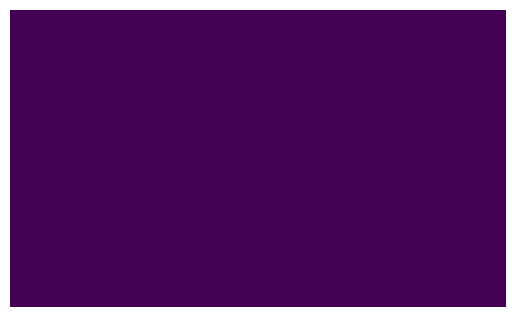

In [65]:
import matplotlib.pyplot as plt
plt.imshow(np.argmin(dist,axis=2))
plt.axis('off')

In [234]:
dist

array([[[0.9528749 , 0.30140358],
        [0.9528749 , 0.30140358],
        [0.9528749 , 0.30140358],
        ...,
        [0.8423333 , 0.2828602 ],
        [0.8423333 , 0.2828602 ],
        [0.8423333 , 0.2828602 ]],

       [[0.9528749 , 0.30140358],
        [0.9528749 , 0.30140358],
        [0.9528749 , 0.30140358],
        ...,
        [0.8423333 , 0.2828602 ],
        [0.8423333 , 0.2828602 ],
        [0.8423333 , 0.2828602 ]],

       [[0.9528749 , 0.30140358],
        [0.9528749 , 0.30140358],
        [0.9528749 , 0.30140358],
        ...,
        [0.8423333 , 0.2828602 ],
        [0.8423333 , 0.2828602 ],
        [0.8423333 , 0.2828602 ]],

       ...,

       [[0.53694654, 0.14748013],
        [0.53694654, 0.14748013],
        [0.53694654, 0.14748013],
        ...,
        [0.43427294, 0.        ],
        [0.43427294, 0.        ],
        [0.43427294, 0.        ]],

       [[0.53694654, 0.14748013],
        [0.53694654, 0.14748013],
        [0.53694654, 0.14748013],
        .

In [50]:
D_Test['Test_Path']

0    ../../FM_Eikonal/data/weizmann_horse_db/horse/...
1    ../../FM_Eikonal/data/weizmann_horse_db/horse/...
Name: Test_Path, dtype: object

# UNET Model

In [701]:
model(data[0])

tensor([[ 0.0024, -0.0931],
        [ 0.0438, -0.1351],
        [-0.1378, -0.0772],
        [-0.0529, -0.0639],
        [ 0.0286, -0.0627],
        [ 0.0005, -0.0141],
        [-0.0656, -0.0208],
        [-0.0633, -0.0611],
        [ 0.1784, -0.1338],
        [ 0.0134, -0.0677],
        [ 0.0254, -0.0833],
        [ 0.0094, -0.0410],
        [-0.0277, -0.0627],
        [ 0.0997, -0.0294],
        [-0.0303, -0.0352],
        [ 0.0375, -0.0977],
        [-0.0243, -0.0341],
        [-0.0653, -0.0612],
        [-0.0384, -0.0383],
        [ 0.0147, -0.1102],
        [ 0.0523, -0.0807],
        [-0.0008, -0.0241],
        [-0.0323, -0.1087],
        [-0.0810, -0.0213],
        [ 0.0399, -0.0621],
        [ 0.0153, -0.0074],
        [ 0.0128, -0.0829],
        [-0.0064, -0.0492],
        [-0.0137, -0.0232],
        [ 0.0066, -0.0842],
        [-0.0165, -0.0823],
        [ 0.0158, -0.1204]], grad_fn=<AddmmBackward0>)

In [688]:
Relu(data[0][:,0,0].unsqueeze(0))

torch.Size([1, 32])

In [692]:
m = nn.ReLU()
input = torch.randn(2).unsqueeze(0)
output = torch.cat((m(input), m(-input)))

In [693]:
input

tensor([[ 0.3380, -0.1105]])

In [696]:
output[0]

tensor([0.3380, 0.0000])

In [127]:
for path_train_im,path_label_im in dset_files[1:]:
    print(f"The training data path is {path_train_im[:-4]}")
    print(f"The training data label path is {path_label_im[:-4]}")
    assert path_train_im.endswith(".png")
    path_train_im = rel_path[1][:-4]
    path_label_im = rel_path[2][:-4]
    self.dsets.append((path_train_im, path_label_im, size_window, c, single_voxel_out=single_voxel_out))

The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse058
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse058
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse187
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse187
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse319
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse319
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse309
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse309
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse126
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse126
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse113
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//h

In [610]:
channel_sequences = {
		0: [1, 64, 128, 256, 512, 1024],
		1: [1,  2,   4,   8,  16,   32],
		2: [1,  4,   8,  16,  32,   64],
		3: [1,  8,  16,  32,  64,  128],
		4: [1, 16,  32,  64, 128,  256],
		5: [1, 32,  64, 128, 256,  512]
	}

dict_values([[1, 64, 128, 256, 512, 1024], [1, 2, 4, 8, 16, 32], [1, 4, 8, 16, 32, 64], [1, 8, 16, 32, 64, 128], [1, 16, 32, 64, 128, 256], [1, 32, 64, 128, 256, 512]])